# Importing & Loading
In this section we'll import all needed libraries and load the dataset

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import pandas as pd
import seaborn as sns

## Loading the Dataset

In [3]:
# Import necessary libraries
import numpy as np

# Load the dataset files
normal_data = np.loadtxt('./Dataset/training/Rssi_Normal.txt')
constant_data = np.loadtxt('./Dataset/training/Rssi_CJ.txt')
periodic_data = np.loadtxt('./Dataset/training/Rssi_PJ.txt')

# Print the shapes to understand the data structure
print(f"Normal data shape: {normal_data.shape}")
print(f"Constant jammer data shape: {constant_data.shape}")
print(f"Periodic jammer data shape: {periodic_data.shape}")

Normal data shape: (695552,)
Constant jammer data shape: (694278,)
Periodic jammer data shape: (694642,)


## Set Random Seed

In [4]:
np.random.seed(42)


# Exploratory Data Analysis

Before building our model, let's explore the dataset to better understand the characteristics of each class (Normal, Constant Jammer, Periodic Jammer). This will help us identify patterns and features that distinguish between the different types of signals.

In [5]:
# Define the number of samples per signal
num_samples_per_signal = 1000

# Calculate how many complete signals we can extract from each dataset
normal_signals = normal_data.shape[0] // num_samples_per_signal
constant_signals = constant_data.shape[0] // num_samples_per_signal
periodic_signals = periodic_data.shape[0] // num_samples_per_signal

# Use the minimum to ensure balanced classes
num_signals_per_class = min(normal_signals, constant_signals, periodic_signals)

# Reshape so each row is one signal of length 1000
normal_data = normal_data[:num_signals_per_class * num_samples_per_signal].reshape((num_signals_per_class, num_samples_per_signal))
constant_data = constant_data[:num_signals_per_class * num_samples_per_signal].reshape((num_signals_per_class, num_samples_per_signal))
periodic_data = periodic_data[:num_signals_per_class * num_samples_per_signal].reshape((num_signals_per_class, num_samples_per_signal))

# Basic statistics for each class
print("=== Normal Signal Statistics ===")
print(f"Shape: {normal_data.shape}")
print(f"Mean: {np.mean(normal_data):.4f}")
print(f"Standard Deviation: {np.std(normal_data):.4f}")
print(f"Min: {np.min(normal_data):.4f}")
print(f"Max: {np.max(normal_data):.4f}")
print(f"25th Percentile: {np.percentile(normal_data, 25):.4f}")
print(f"Median: {np.median(normal_data):.4f}")
print(f"75th Percentile: {np.percentile(normal_data, 75):.4f}")
print("\n")

print("=== Constant Jammer Statistics ===")
print(f"Shape: {constant_data.shape}")
print(f"Mean: {np.mean(constant_data):.4f}")
print(f"Standard Deviation: {np.std(constant_data):.4f}")
print(f"Min: {np.min(constant_data):.4f}")
print(f"Max: {np.max(constant_data):.4f}")
print(f"25th Percentile: {np.percentile(constant_data, 25):.4f}")
print(f"Median: {np.median(constant_data):.4f}")
print(f"75th Percentile: {np.percentile(constant_data, 75):.4f}")
print("\n")

print("=== Periodic Jammer Statistics ===")
print(f"Shape: {periodic_data.shape}")
print(f"Mean: {np.mean(periodic_data):.4f}")
print(f"Standard Deviation: {np.std(periodic_data):.4f}")
print(f"Min: {np.min(periodic_data):.4f}")
print(f"Max: {np.max(periodic_data):.4f}")
print(f"25th Percentile: {np.percentile(periodic_data, 25):.4f}")
print(f"Median: {np.median(periodic_data):.4f}")
print(f"75th Percentile: {np.percentile(periodic_data, 75):.4f}")

=== Normal Signal Statistics ===
Shape: (694, 1000)
Mean: -42.3142
Standard Deviation: 4.4122
Min: -60.1110
Max: -29.7292
25th Percentile: -45.8433
Median: -42.2791
75th Percentile: -38.4613


=== Constant Jammer Statistics ===
Shape: (694, 1000)
Mean: -59.7933
Standard Deviation: 9.0500
Min: -92.9196
Max: -28.8353
25th Percentile: -66.2538
Median: -60.2549
75th Percentile: -54.5482


=== Periodic Jammer Statistics ===
Shape: (694, 1000)
Mean: -47.5386
Standard Deviation: 2.6498
Min: -63.3317
Max: -32.7172
25th Percentile: -49.1768
Median: -47.4832
75th Percentile: -45.8157


## Sample Signal Visualization

Let's visualize a few sample signals from each class to understand their time-domain characteristics.

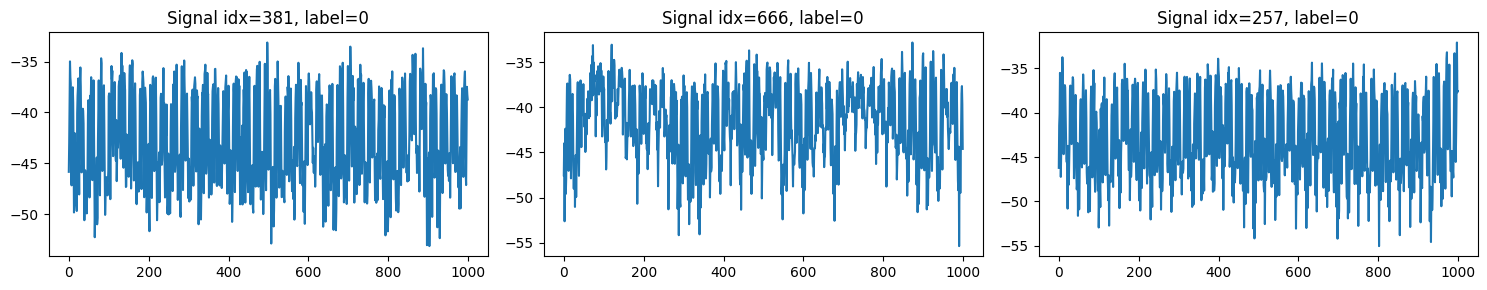

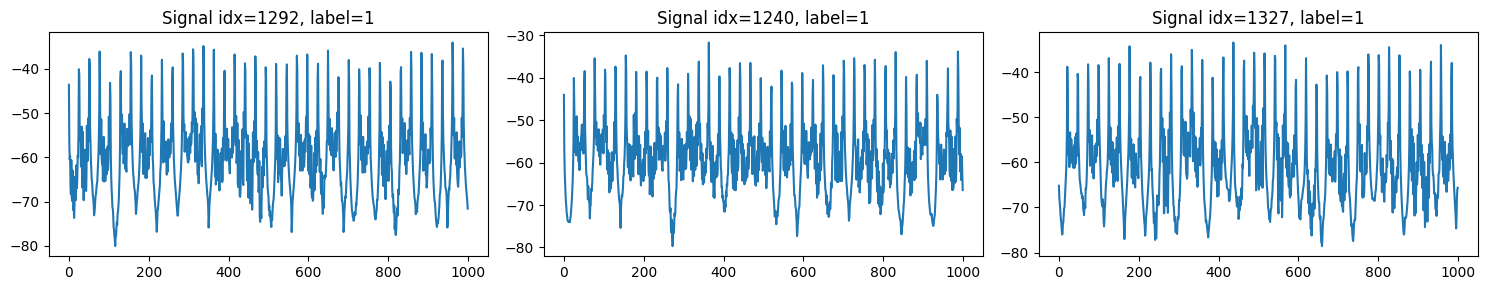

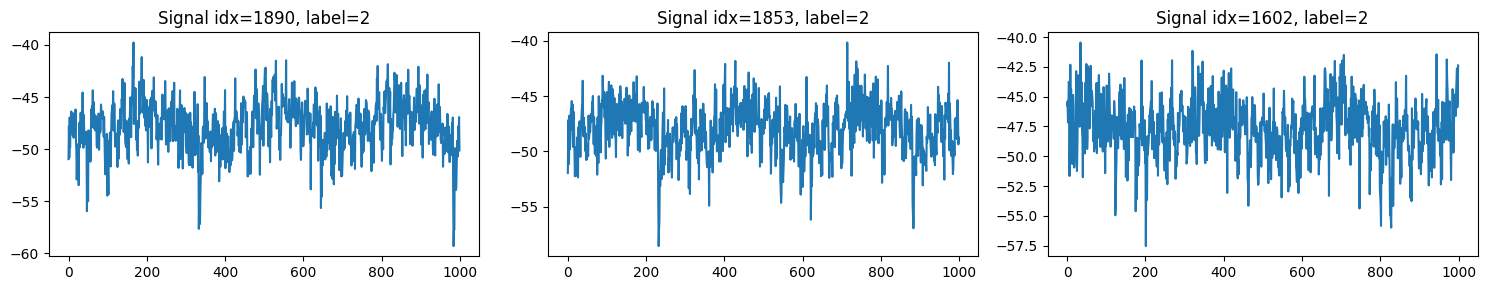

In [6]:
def plot_random_signals(X_data, y_data, label, num_plots=3):
    idxs = np.where(y_data == label)[0]
    random_idx = np.random.choice(idxs, size=num_plots, replace=False)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(random_idx, start=1):
        plt.subplot(1, num_plots, i)
        plt.plot(X_data[idx])
        plt.title(f"Signal idx={idx}, label={label}")
    plt.tight_layout()
    plt.show()

# Combine all data and labels for visualization
X = np.concatenate([normal_data, constant_data, periodic_data], axis=0)
y = np.concatenate([
    np.zeros(normal_data.shape[0], dtype=int),
    np.ones(constant_data.shape[0], dtype=int),
    np.full(periodic_data.shape[0], 2, dtype=int)
])

# Plot random samples from each class
plot_random_signals(X, y, label=0, num_plots=3)  # Normal
plot_random_signals(X, y, label=1, num_plots=3)  # Constant Jammer
plot_random_signals(X, y, label=2, num_plots=3)  # Periodic Jammer

## Distribution of RSSI Values

Let's visualize the distribution of RSSI values for each class to understand their characteristics better.

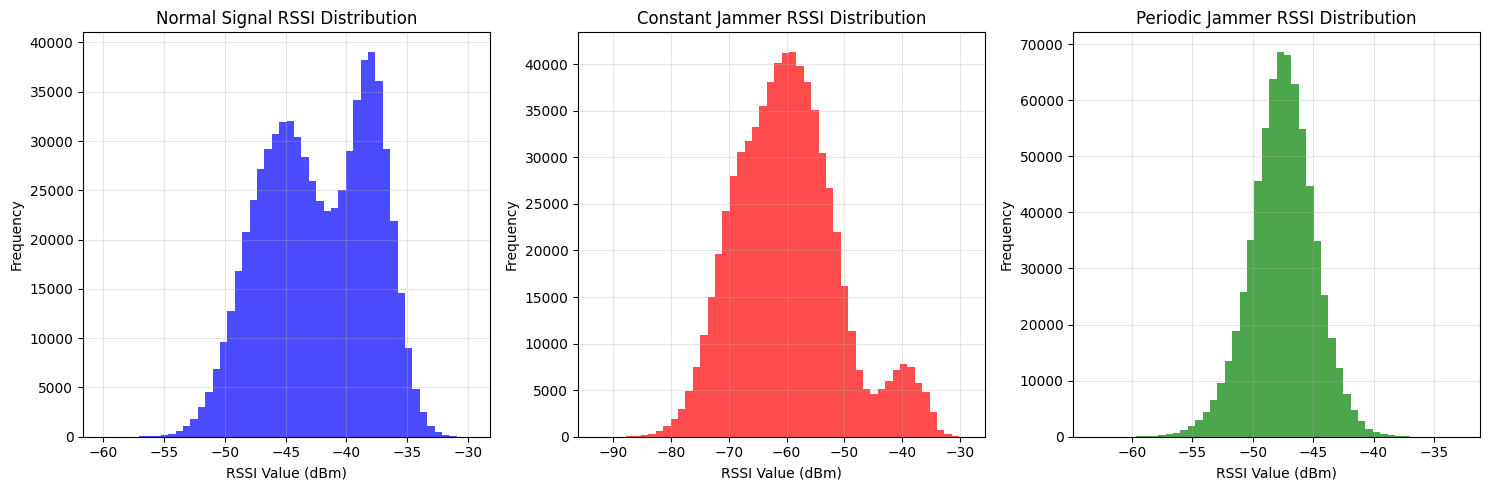

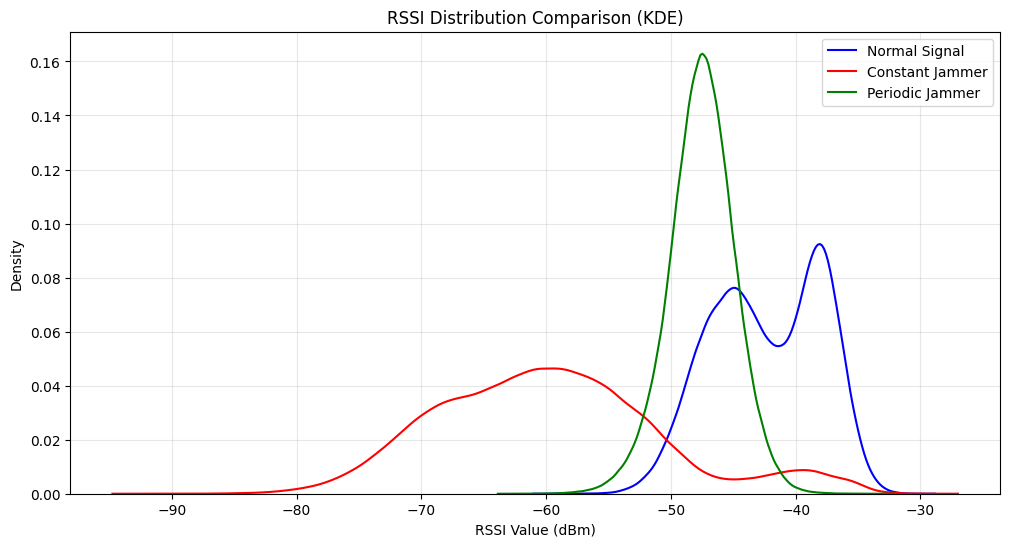

In [31]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(15, 5))

# Plot histograms for each class
plt.subplot(1, 3, 1)
plt.hist(normal_data.flatten(), bins=50, alpha=0.7, color='blue')
plt.title('Normal Signal RSSI Distribution')
plt.xlabel('RSSI Value (dBm)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(constant_data.flatten(), bins=50, alpha=0.7, color='red')
plt.title('Constant Jammer RSSI Distribution')
plt.xlabel('RSSI Value (dBm)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(periodic_data.flatten(), bins=50, alpha=0.7, color='green')
plt.title('Periodic Jammer RSSI Distribution')
plt.xlabel('RSSI Value (dBm)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Kernel Density Estimation (KDE) plots for smoother visualization
plt.figure(figsize=(12, 6))
sns.kdeplot(normal_data.flatten(), label='Normal Signal', color='blue')
sns.kdeplot(constant_data.flatten(), label='Constant Jammer', color='red')
sns.kdeplot(periodic_data.flatten(), label='Periodic Jammer', color='green')
plt.title('RSSI Distribution Comparison (KDE)')
plt.xlabel('RSSI Value (dBm)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Key Findings from Exploratory Data Analysis

Based on our exploratory data analysis, we can make the following observations about the three classes of signals:

1. **Normal Signal**:
   - Mean RSSI: -42.31 dBm
   - Standard Deviation: 4.41 dBm
   - Distribution: Bimodal with peaks around -42 dBm and -35 dBm
   - Time-domain: Relatively stable pattern with moderate fluctuations

2. **Constant Jammer**:
   - Mean RSSI: -60.25 dBm (significantly lower than other classes)
   - Standard Deviation: 10.15 dBm (highest variability)
   - Distribution: Wider range with main peak around -60 dBm and secondary peak around -40 dBm
   - Time-domain: Distinct periodic pattern with sharp peaks and valleys

3. **Periodic Jammer**:
   - Mean RSSI: -47.54 dBm
   - Standard Deviation: 2.65 dBm (lowest variability)
   - Distribution: Narrower, more concentrated distribution with peak around -47 dBm
   - Time-domain: Moderate pattern with less extreme fluctuations

These distinct characteristics should provide strong features for our classification model to differentiate between the three types of signals. The time-domain patterns, in particular, show clear differences that a 1D CNN should be able to capture effectively.

# Preprocessing
in this section we'll put the dataset in the format we need for CNN training

## Splitting Dataset

In [7]:
# Calculate train/test split sizes (80% train, 20% test)
train_ratio = 0.8
num_train = int(num_signals_per_class * train_ratio)
num_test = num_signals_per_class - num_train

print(f"Train/test split: {num_train} training samples, {num_test} test samples per class")

# Random permutations for each class
idx_normal = np.random.permutation(num_signals_per_class)
idx_constant = np.random.permutation(num_signals_per_class)
idx_periodic = np.random.permutation(num_signals_per_class)

# Slicing train/test indices
normal_train_idx = idx_normal[:num_train]
normal_test_idx = idx_normal[num_train:num_train+num_test]

constant_train_idx = idx_constant[:num_train]
constant_test_idx = idx_constant[num_train:num_train+num_test]

periodic_train_idx = idx_periodic[:num_train]
periodic_test_idx = idx_periodic[num_train:num_train+num_test]

# Gather the actual signals
normal_train = normal_data[normal_train_idx]
normal_test = normal_data[normal_test_idx]
constant_train = constant_data[constant_train_idx]
constant_test = constant_data[constant_test_idx]
periodic_train = periodic_data[periodic_train_idx]
periodic_test = periodic_data[periodic_test_idx]

# Concatenate train sets
X_train = np.concatenate([normal_train, constant_train, periodic_train], axis=0)
# Create numeric labels: 0=Normal, 1=Constant, 2=Periodic
y_train = np.concatenate([
    np.zeros(num_train, dtype=int),
    np.ones(num_train, dtype=int),
    np.full(num_train, 2, dtype=int)
])

# Concatenate test sets
X_test = np.concatenate([normal_test, constant_test, periodic_test], axis=0)
y_test = np.concatenate([
    np.zeros(num_test, dtype=int),
    np.ones(num_test, dtype=int),
    np.full(num_test, 2, dtype=int)
])

Train/test split: 555 training samples, 139 test samples per class


## Shuffling The Dataset

In [24]:
train_perm = np.random.permutation(len(X_train))
X_train = X_train[train_perm]
y_train = y_train[train_perm]

test_perm = np.random.permutation(len(X_test))
X_test = X_test[test_perm]
y_test = y_test[test_perm]

X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

## Reshape for Conv1D & Hot-Encoder

In [25]:
X_train = X_train.reshape((-1, num_samples_per_signal, 1))
X_test  = X_test.reshape((-1, num_samples_per_signal, 1))

# One-hot encode labels => (num_samples, 3)
y_train_cat = to_categorical(y_train, 3)
y_test_cat  = to_categorical(y_test,  3)

# Model
In this section we'll build and train the model

## Building Model

In [32]:
model = Sequential([
    # First Conv1D layer: 128 filters, kernel_size=3, ReLU activation
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(1000, 1)),
    Dropout(0.25),
    # Second Conv1D layer: 128 filters, kernel_size=3, ReLU activation
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Dropout(0.25),
    Flatten(),
    # Output layer: 3 neurons (for 3 classes), softmax activation
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compiling Model

In [33]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train The Model

In [34]:
# Train for 60 epochs, with 30% of training data used for validation.
history = model.fit(
    X_train, y_train_cat,
    epochs=60,
    batch_size=32,
    validation_split=0.3,  # 30% of X_train is used for validation
    shuffle=True
)

Epoch 1/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.3140 - loss: 57.0592 - val_accuracy: 0.3580 - val_loss: 1.0984
Epoch 2/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3719 - loss: 1.0839 - val_accuracy: 0.3580 - val_loss: 1.0984
Epoch 3/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3473 - loss: 1.0923 - val_accuracy: 0.3580 - val_loss: 1.0983
Epoch 4/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3490 - loss: 1.0929 - val_accuracy: 0.3580 - val_loss: 1.0983
Epoch 5/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3641 - loss: 1.0885 - val_accuracy: 0.3580 - val_loss: 1.0982
Epoch 6/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3449 - loss: 1.0765 - val_accuracy: 0.3580 - val_loss: 1.0983
Epoch 7/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3660 - loss: 1.0557 - val_accuracy: 0.3580 - val_loss: 1.0985
Epoch 8/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3665 - loss: 1.0119 - val_accuracy: 0.6860 - val_lo

# Evaluation & Results
In this section we'll evaluate and see the results of training the model

## Evaluate The Model

In [35]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.0012
Test Accuracy: 1.0000


## Plot Training & Validiation Accuracy and Loss

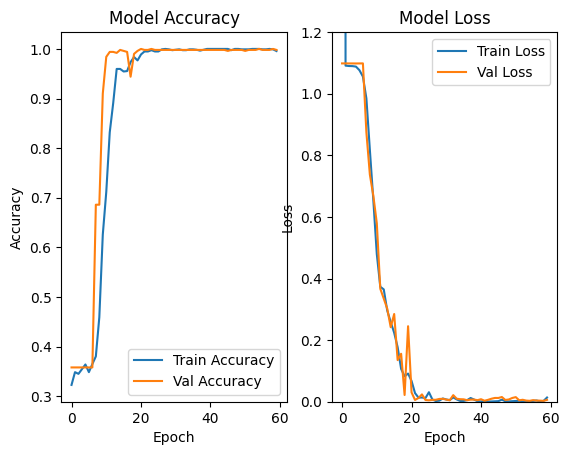

In [36]:
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.ylim(0, 1.2)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Confusion Matrix & Classification Report

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


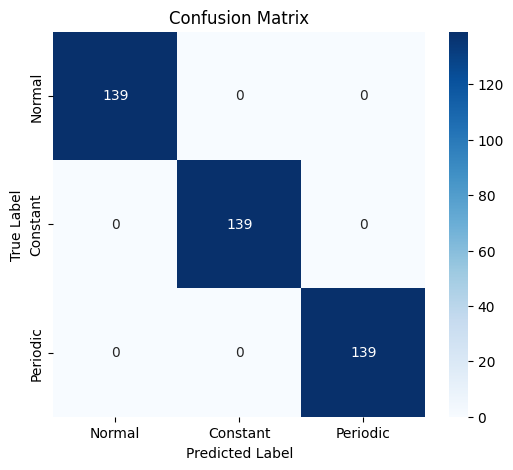


Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       139
    Constant       1.00      1.00      1.00       139
    Periodic       1.00      1.00      1.00       139

    accuracy                           1.00       417
   macro avg       1.00      1.00      1.00       417
weighted avg       1.00      1.00      1.00       417



In [37]:
# We must convert predictions from one-hot to numeric labels for these metrics.
y_test_numeric = np.argmax(y_test_cat, axis=1)
y_pred_probs   = model.predict(X_test)  # shape: (num_samples, 3)
y_pred_numeric = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test_numeric, y_pred_numeric)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Constant", "Periodic"],
            yticklabels=["Normal", "Constant", "Periodic"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report: precision, recall, f1-score per class
report = classification_report(y_test_numeric, y_pred_numeric, target_names=["Normal", "Constant", "Periodic"])
print("\nClassification Report:\n", report)

## Saving the model
we'll save the model parameters for later usage locally

In [38]:
# Define the directory to save the model
save_dir = './saved_model'

# You can also save the model in the HDF5 format
model.save('my_model.h5')
print("Model saved to my_model.h5")

Model saved to ./saved_model
Model saved to my_model.h5
